## 04.P Geospatial Data Problem Set – Summarizing Airborne Snow Observatory Data

__Background:__ For your graduate research, you are using lidar-derived snow water equivalent (SWE) estimates to assimilate into a physics based hydrology model to make streamflow predictions. In thinking through your hypotheses portions of the landscape where SWE data will have the most impact, you are reminded of a figure you saw in a presentation at a recent meeting. The figure shows how the distribution of SWE and land area across a range of elevation interact to control the distribution of water storage in the landscape. The figure looked like the following:

<img src='../img/aso_swe.png' alt='Upper Colorado ASO Analysis' width='750' style='display: block; margin: 0 auto'/>

You already have grids of estimated SWE from the Airborne Snow Observatory (ASO) for 4 separate dates at a 50 m spatial resolution, and a coregistered digital elevation model of the study area – the East River in the Colorado Rocky Mountains.  

__Task:__ Use the skills you've developed and the example notebooks you've examined in this module to create an image like the above. The ASO and coregistered DEM can be found in [this Google Drive folder](https://drive.google.com/drive/u/0/folders/1SkjOWPPJe5N25arCW6qbf2ZJWQsrUAAp). Use any of the four ASO files, which corresponds to 2 different dates in 2018 or 2019, or write your code generically to plot any or all dates. You should only need `rasterio`, `numpy`, and `matplotlib` to create this figure.    

In [14]:
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

read_file = 'C:/Users/maggiedart/Documents/mmd-geos505/ASO Data/ASO_50M_SWE_USCOGE_20180331.tif'
read_file2 = 'C:/Users/maggiedart/Documents/mmd-geos505/ASO Data/ASO_50M_SWE_USCOGE_20180524.tif'   
#read_file3 = 'C:/Users/maggiedart/Documents/mmd-geos505/ASO Data/ASO_50M_SWE_USCOGE_20190407.tif'
#read_file4 = 'C:/Users/maggiedart/Documents/mmd-geos505/ASO Data/ASO_50M_SWE_USCOGE_20190610.tif'
    

In [15]:
with rio.open(read_file) as dataset1:
    dem = dataset1.read(1).astype(float)
    dem_nodata = dataset1.nodata
    transform = dataset1.transform
    cell_area = abs(transform[0] * transform[4])   # ~2500 m² for 50 m pixels

with rio.open(read_file2) as dataset2:
    swe = dataset2.read(1).astype(float)
    swe_nodata = dataset2.nodata

#with rio.open(read_file3) as dataset3:
 #   swe2 = dataset3.read(1).astype(float)    

#with rio.open(read_file4) as dataset4:
 #   swe3 = dataset4.read(1).astype(float)        

# Mask nodata
if dem_nodata is not None:
    dem = np.where(dem == dem_nodata, np.nan, dem)

if swe_nodata is not None:
    swe = np.where(swe == swe_nodata, np.nan, swe)

# SWE invalid where DEM invalid
swe = np.where(np.isnan(dem), np.nan, swe)

In [16]:
# -------------------------
# Elevation binning
# -------------------------
bin_width = 100
elev_min = np.nanmin(dem)
elev_max = np.nanmax(dem)
bins = np.arange(elev_min, elev_max + bin_width, bin_width)
inds = np.digitize(dem, bins)
bin_centers = bins

# Initialize arrays
mean_swe = np.zeros(len(bins))
median_swe = np.zeros(len(bins))
std_swe = np.zeros(len(bins))
area = np.zeros(len(bins))
swe_volume = np.zeros(len(bins))

for i in range(1, len(bins)):
    mask = inds == i
    values = swe[mask]

    # SWE stats
    mean_swe[i] = np.nanmean(values)
    median_swe[i] = np.nanmedian(values)
    std_swe[i] = np.nanstd(values)

    # area distribution
    area[i] = np.sum(mask) * cell_area / 1e6  # km²

    # SWE volume
    swe_volume[i] = np.nansum(values * cell_area) / 1e6  # Mm³

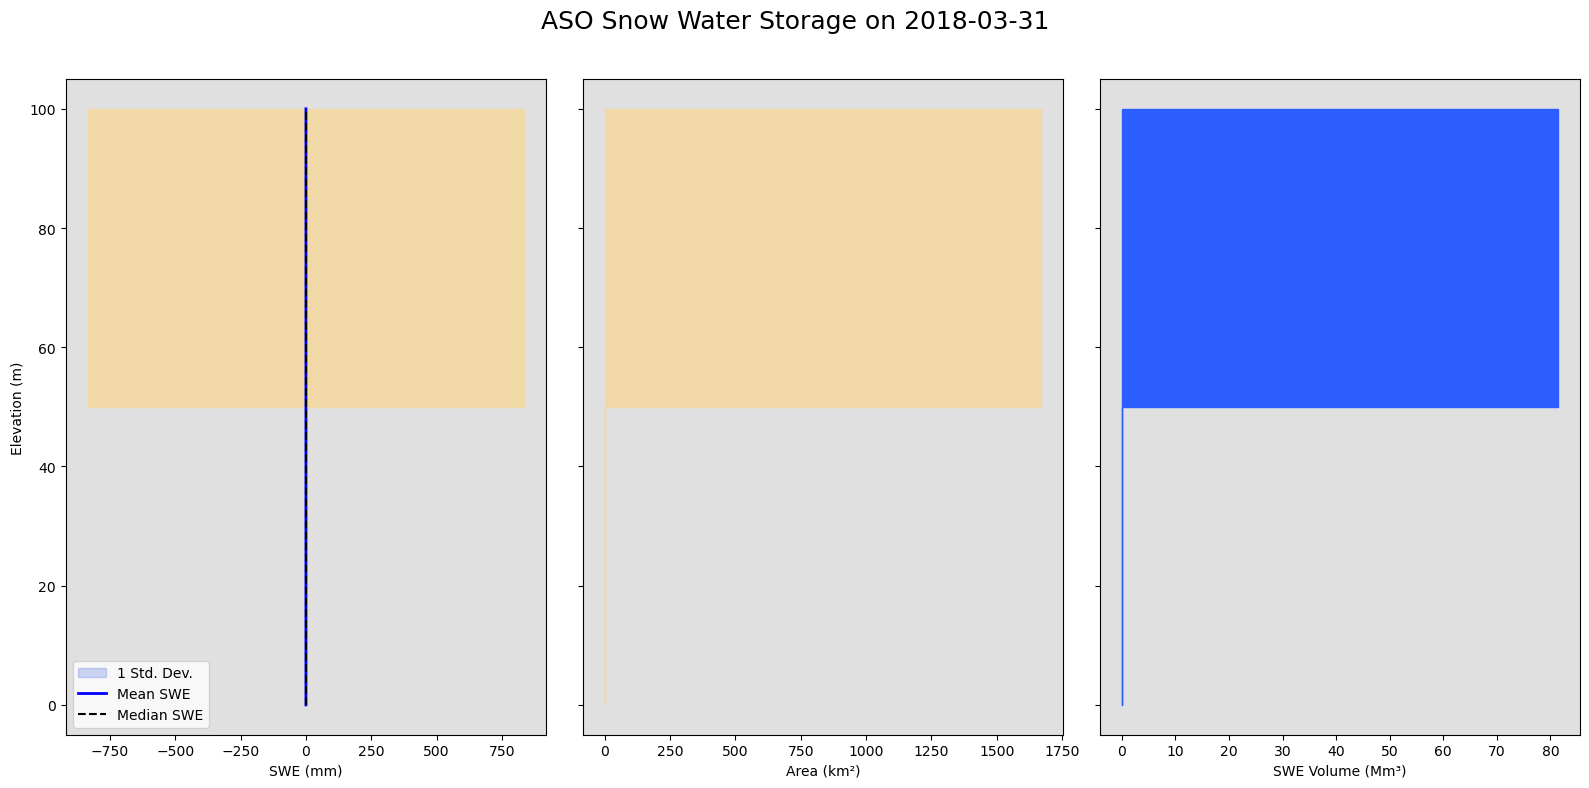

In [ ]:
# -------------------------
# Plotting
# -------------------------
fig, axes = plt.subplots(1, 3, figsize=(16, 8), sharey=True)
fig.suptitle("ASO Snow Water Storage on 2018-03-31", fontsize=18)

# y-axis = elevation
y = bin_centers

# ------------------------------------------------------------------
# LEFT PANEL — SWE statistics
# ------------------------------------------------------------------
ax = axes[0]
ax.set_facecolor("#e0e0e0")

ax.fill_betweenx(y, mean_swe - std_swe, mean_swe + std_swe,
                 color="royalblue", alpha=0.25, label="1 Std. Dev.")
ax.fill_betweenx(y, -area/2, area/2, step="mid", color="#f0d9a7")


ax.plot(mean_swe, y, color="blue", linewidth=2, label="Mean SWE")
ax.plot(median_swe, y, color="black", linestyle="--", linewidth=1.5,
        label="Median SWE")

ax.set_xlabel("SWE (mm)")
ax.set_ylabel("Elevation (m)")
ax.legend()

# ------------------------------------------------------------------
# MIDDLE PANEL — Area distribution
# ------------------------------------------------------------------
ax = axes[1]
ax.set_facecolor("#e0e0e0")

# Draw a filled horizontal histogram-style polygon
ax.fill_betweenx(y, 0, area, step="mid", color="#f0d9a7")

ax.set_xlabel("Area (km²)")

# ------------------------------------------------------------------
# RIGHT PANEL — SWE Volume distribution
# ------------------------------------------------------------------
ax = axes[2]
ax.set_facecolor("#e0e0e0")

ax.fill_betweenx(y, 0, swe_volume, step="mid", color="#2b5dff")
#ax.fill_betweenx(y, -swe_volume/2, swe_volume/2, step="mid", color="#2b5dff")

ax.set_xlabel("SWE Volume (Mm³)")

# Layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
